<a href="https://colab.research.google.com/github/lululxvi/deepxde/blob/master/examples/Lorenz_inverse_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and functions

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# get training data
def gen_traindata():
    response = requests.get('https://github.com/lululxvi/deepxde/raw/master/examples/dataset/Lorenz.npz')
    response.raise_for_status()
    data = np.load(io.BytesIO(response.content))
    return data["t"], data["y"]

# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8/3

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

def boundary(_, on_initial):
    return on_initial

Define data and BCs

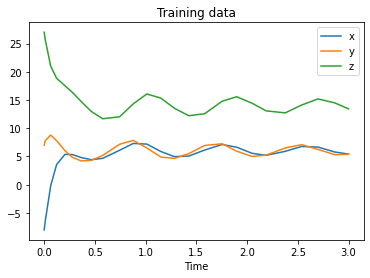

In [3]:
# define time domain
geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 27, boundary, component=2)

# Get the training data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

# define data object
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

plt.plot(observe_t, ob_y)
plt.xlabel('Time')
plt.legend(['x','y','z'])
plt.title('Training data')
plt.show()

Train network

In [4]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.051860 s



c:\programdata\anaconda3\envs\deepxde\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\programdata\anaconda3\envs\deepxde\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.912562 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.46e-01, 1.84e-01, 4.76e-02, 6.40e+01, 4.90e+01, 7.29e+02, 3.12e+01, 3.98e+01, 2.61e+02]    [2.46e-01, 1.84e-01, 4.76e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [4.89e+00, 3.11e+00, 3.08e+00, 3.37e+01, 8.84e-03, 2.04e+00, 3.33e+01, 7.00e+00, 1.01e+01]    [4.89e+00, 3.11e+00, 3.08e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [9.13e+00, 1.91e+00, 1.17e+00, 1.60e+01, 3.32e-01, 1.57e+00, 3.29e+01, 1.62e+01, 4.03e+00]    [9.13e+00, 1.91e+00, 1.17e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [8.61e+00, 1.98e+00, 8.77e-01, 1.28e+01, 3.90e-01, 1.44e+00, 3.28e+01, 1.89e+01, 2.73e+00]    [8.61

39000     [4.68e-03, 5.63e-03, 7.23e-03, 5.10e-06, 1.36e-05, 1.22e-06, 3.59e-04, 4.94e-04, 8.27e-04]    [4.68e-03, 5.63e-03, 7.23e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
40000     [5.08e-03, 5.32e-03, 7.24e-03, 2.37e-07, 5.42e-05, 2.13e-05, 3.34e-04, 4.54e-04, 7.62e-04]    [5.08e-03, 5.32e-03, 7.24e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
41000     [4.50e-03, 5.10e-03, 6.95e-03, 8.81e-06, 5.21e-05, 3.51e-05, 3.15e-04, 4.29e-04, 7.16e-04]    [4.50e-03, 5.10e-03, 6.95e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
42000     [4.37e-03, 4.75e-03, 6.73e-03, 3.51e-06, 1.47e-05, 5.68e-08, 2.81e-04, 3.90e-04, 6.62e-04]    [4.37e-03, 4.75e-03, 6.73e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
43000     [4.26e-03, 4.51e-03, 6.57e-03, 3.30e-06, 1.34e-05, 1.65e-07, 2.65e-04, 3.70e-04, 6.29e-04]    [4.26e-03, 4.51e-03, 6.57e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.0

 Plot identified parameters

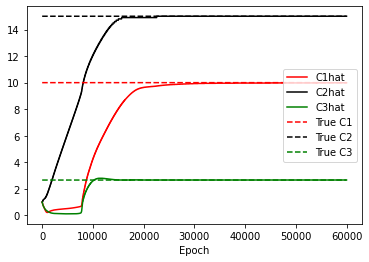

In [5]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

Predicting...
'predict' took 0.010971 s



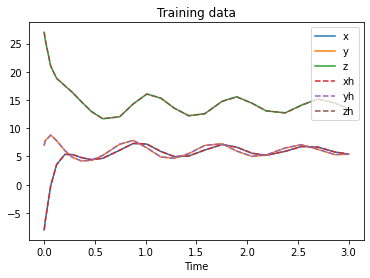

In [6]:
yhat = model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()